# pitch 추출 베이스라인

In [ ]:
!pip install praat-parselmouth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 50.8 MB/s eta 0:00:00


In [ ]:
# pitch 데이터 추출 및 시각화
import parselmouth
from parselmouth.praat import call
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 문미억양 pitch slope 추출

# import parselmouth
# import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [ ]:
audio_file = "/content/drive/MyDrive/aiffel/aiffelthon/cleanSound.wav"

## 1. pitch 데이터 추출 및 시각화

- 필요한 라이브러리:

  parselmouth: 음성 파일에서 pitch 데이터를 추출합니다.
  matplotlib: 추출된 pitch 데이터를 시각화합니다.
  numpy: Voiceless 구간을 NaN으로 처리합니다.
- 함수:

  extract_pitch_contour: 음성 파일에서 pitch 데이터를 추출하고, 시간 배열(times)과 주파수 배열(pitch_values)을 반환합니다.
  visualize_pitch_contour: 추출된 pitch 데이터를 시간에 따라 시각화합니다.
- Pitch 범위 설정:

  to_pitch()에서 75Hz~500Hz의 범위를 사용해 인간 음성의 일반적인 pitch를 추출합니다.
- Voiceless 구간 처리:

  Voiceless (무성음) 구간은 0으로 표시되며, 이를 NaN으로 변환해 그래프에서 표시하지 않습니다.

In [ ]:
# 음성 파일에서 Pitch를 추출하는 함수
def extract_pitch_contour(audio_path):
    try:
        # 음성 파일 읽기
        sound = parselmouth.Sound(audio_path)

        # Pitch 추출 (범위: 75Hz ~ 500Hz)
        pitch = sound.to_pitch()
        pitch_values = pitch.selected_array['frequency']
        pitch_values[pitch_values == 0] = np.nan  # Voiceless 구간 제거
        times = pitch.xs()

        return times, pitch_values
    except Exception as e:
        print(f"Error processing file {audio_path}: {e}")
        return None, None

# Pitch contour를 시각화하는 함수
def visualize_pitch_contour(times, pitch_values):
    plt.figure(figsize=(10, 6))
    plt.plot(times, pitch_values, label="Pitch contour", color="blue")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Pitch Contour")
    plt.legend()
    plt.grid()
    plt.show()




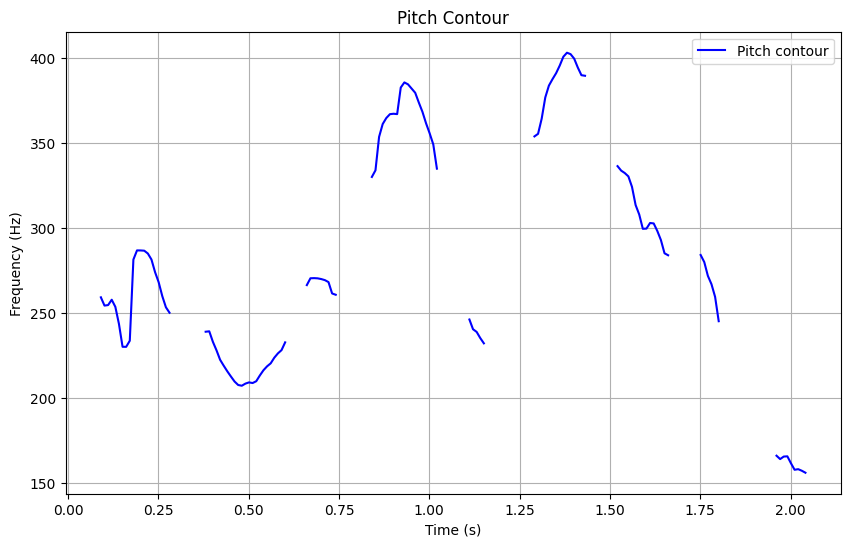

In [ ]:
# 사용 예시
if __name__ == "__main__":
    audio_file = "/content/drive/MyDrive/aiffel/aiffelthon/cleanSound.wav"  # 분석할 음성 파일 경로를 입력하세요.

    # Pitch 추출 및 시각화
    times, pitch_values = extract_pitch_contour(audio_file)
    if times is not None and pitch_values is not None:
        visualize_pitch_contour(times, pitch_values)

In [ ]:
def extract_pitch_contour(audio_path, time_step=0.00005):
    try:
        # 음성 파일 읽기
        sound = parselmouth.Sound(audio_path)

        # Pitch 추출 (범위: 150Hz ~ 450Hz, time_step 설정)
        pitch = sound.to_pitch(pitch_floor=150, pitch_ceiling=450, time_step=time_step)
        pitch_values = pitch.selected_array['frequency']
        pitch_values[pitch_values == 0] = np.nan  # Voiceless 구간 제거
        times = pitch.xs()

        return times, pitch_values
    except Exception as e:
        print(f"Error processing file {audio_path}: {e}")
        return None, None


## 2. boundary tone 구간 내 pitch 기울기 계산 및 시각화

# 3. 피치파생 특징 추출

- 한국어 문미억양 강조를 통한 향상된 음성문장 감정인식

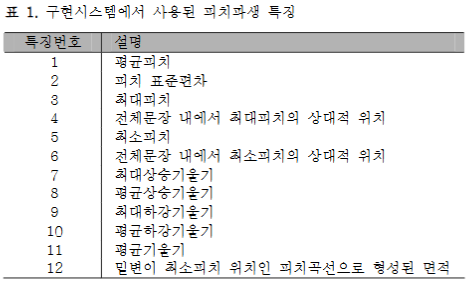


In [ ]:
import parselmouth
from parselmouth.praat import call
import numpy as np
import matplotlib.pyplot as plt

def extract_pitch_contour(audio_path):
    try:
        # 음성 파일 읽기
        sound = parselmouth.Sound(audio_path)

        # Pitch 추출 (범위: 150Hz ~ 450Hz)
        pitch = sound.to_pitch(pitch_floor=150, pitch_ceiling=450)
        pitch_values = pitch.selected_array['frequency']
        pitch_values[pitch_values == 0] = np.nan  # Voiceless 구간 제거
        times = pitch.xs()

        return times, pitch_values
    except Exception as e:
        print(f"Error processing file {audio_path}: {e}")
        return None, None

def calculate_features(times, pitch_values):
    # NaN 제거
    valid_indices = ~np.isnan(pitch_values)
    valid_times = times[valid_indices]
    valid_pitches = pitch_values[valid_indices]

    if len(valid_pitches) == 0:
        raise ValueError("No valid pitch values available for feature extraction.")

    # 특징 계산
    mean_pitch = np.mean(valid_pitches)  # 1. 평균 피치
    std_pitch = np.std(valid_pitches)   # 2. 피치 표준편차
    max_pitch = np.max(valid_pitches)  # 3. 최대 피치
    min_pitch = np.min(valid_pitches)  # 5. 최소 피치

    max_pitch_time = valid_times[np.argmax(valid_pitches)]  # 4. 최대 피치의 상대적 위치
    min_pitch_time = valid_times[np.argmin(valid_pitches)]  # 6. 최소 피치의 상대적 위치

    pitch_range = max_pitch - min_pitch  # 7. 최대 상승 기울기 (단순 범위로 계산)

    avg_rise_slope = np.mean(np.diff(valid_pitches) / np.diff(valid_times))  # 8. 평균 상승 기울기
    avg_fall_slope = -np.mean(np.diff(valid_pitches) / np.diff(valid_times)) # 9. 평균 하강 기울기

    mid_pitch = (max_pitch + min_pitch) / 2  # 10. 중간값

    # 11. 평균 기울기
    slopes = np.diff(valid_pitches) / np.diff(valid_times)
    avg_slope = np.mean(slopes)

    # 12. 마지막 최소 피치 구간의 면적
    end_time = valid_times[-1]
    boundary_start_time = end_time - 0.5  # 0.5초 간격을 하드코딩
    boundary_mask = valid_times >= boundary_start_time
    boundary_times = valid_times[boundary_mask]
    boundary_pitches = valid_pitches[boundary_mask]
    boundary_area = np.trapz(boundary_pitches, boundary_times) if len(boundary_times) > 1 else 0

    return {
        "mean_pitch": mean_pitch,
        "std_pitch": std_pitch,
        "max_pitch": max_pitch,
        "max_pitch_time": max_pitch_time,
        "min_pitch": min_pitch,
        "min_pitch_time": min_pitch_time,
        "pitch_range": pitch_range,
        "avg_rise_slope": avg_rise_slope,
        "avg_fall_slope": avg_fall_slope,
        "mid_pitch": mid_pitch,
        "avg_slope": avg_slope,
        "boundary_area": boundary_area
    }

def visualize_pitch(times, pitch_values):
    plt.figure(figsize=(10, 6))
    plt.plot(times, pitch_values, label="Pitch Contour", color="blue")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Pitch Contour")
    plt.grid()
    plt.legend()
    plt.show()




mean_pitch: 283.946149762495
std_pitch: 69.49073901253821
max_pitch: 403.38105958803044
max_pitch_time: 1.381
min_pitch: 155.22723847317863
min_pitch_time: 2.036
pitch_range: 248.1538211148518
avg_rise_slope: -96.5848204738656
avg_fall_slope: 96.5848204738656
mid_pitch: 279.30414903060455
avg_slope: -96.5848204738656
boundary_area: 119.60743947140737


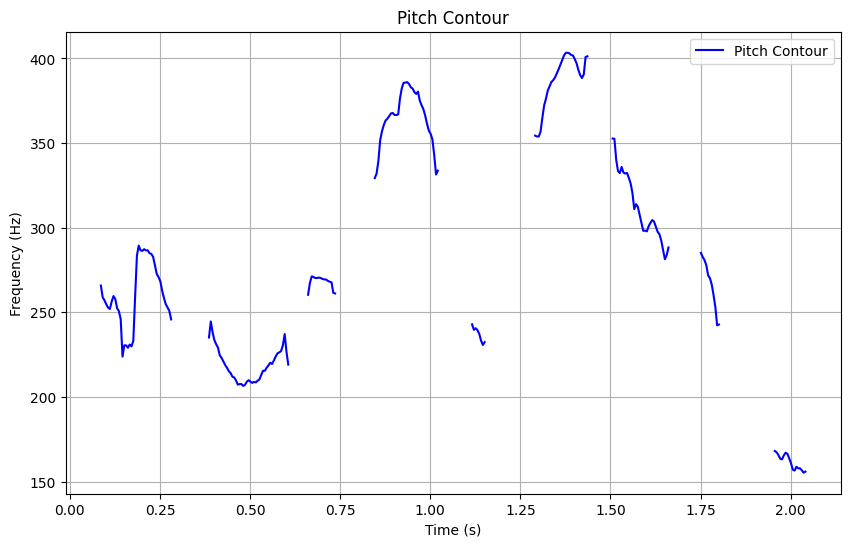

In [ ]:
# 사용 예시
if __name__ == "__main__":
    audio_file = "/content/drive/MyDrive/aiffel/aiffelthon/cleanSound.wav"  # 분석할 음성 파일 경로를 입력하세요.
    times, pitch_values = extract_pitch_contour(audio_file)

    if times is not None and pitch_values is not None:
        try:
            features = calculate_features(times, pitch_values)
            for feature_name, value in features.items():
                print(f"{feature_name}: {value}")

            visualize_pitch(times, pitch_values)
        except ValueError as e:
            print(e)

# 5. 마지막 음절 구간에서의 pitch contour 기울기와 IP 주석(boundary tone)

(1) 주어진 음성 파일에서 마지막 음절 구간의 pitch contour를 추출하고, 이를 기반으로 억양 주석을 달기 위한 작업 흐름 baseline code

(2) 억양 자동 전사는 Praat이나 Parselmouth로 처리할 수 없으므로, 이를 위해 Python으로 기본적인 억양 패턴을 식별하고 주석을 생성

(3) 주요 단계
- Pitch Contour 추출 및 보간
- 마지막 음절 구간을 포함한 pitch 데이터를 필터링
- 음절 구간을 기준으로, pitch 데이터 분석 및 특정 패턴(상승, 하강, 평탄 등)을 자동으로 감지하여 주석을 달도록 구현


pitch slope를 구하기 위한 구간을, 외부에서 인자로 입력받은 마지막 음절 발화 시간으로 두고, 해당 구간 내에서 pitch의 시작점과 끝점 사이 기울기를 구한다.

그리고 기울기에 따라 억양 주석을 단다. 억양 주석은 총 4가지 경우에 따라 2개 중 하나로 달며, 해당 기울기가 양의 기울기이면 오름조 (H%),  음의 기울기이면 내림조 (L%)이다.

해당 구간(마지막 음절) 내의 pitch 기울기가 평탄한 편이라면, 마지막 음절 구간(intonation phrase) 진입 직전까지 측정된 pitch 값이 전체 문장의 pitch에 비해 높은 편인지 낮은 편인지 확인하여 L%와 H% 중 하나로 주석을 단다. 즉, 전체적으로 높은 pitch이면 H%, 낮은 피치이면 L%이다.

### 마지막 음절 임의로 재설정 후 다시 확인

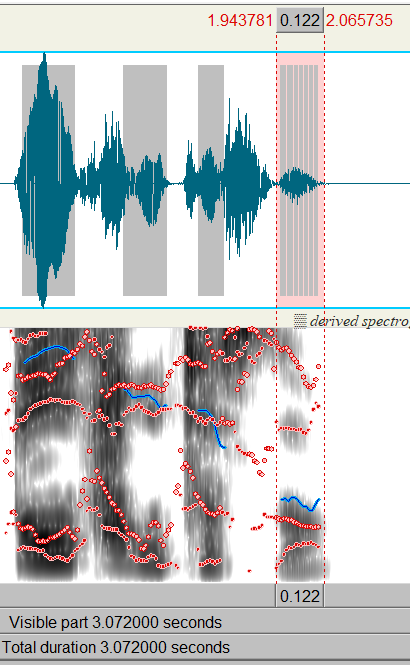

In [ ]:
# import numpy as np
from scipy import interpolate
from scipy.interpolate import interp1d

### 사람이 듣고 결정한 마지막 음절 구간

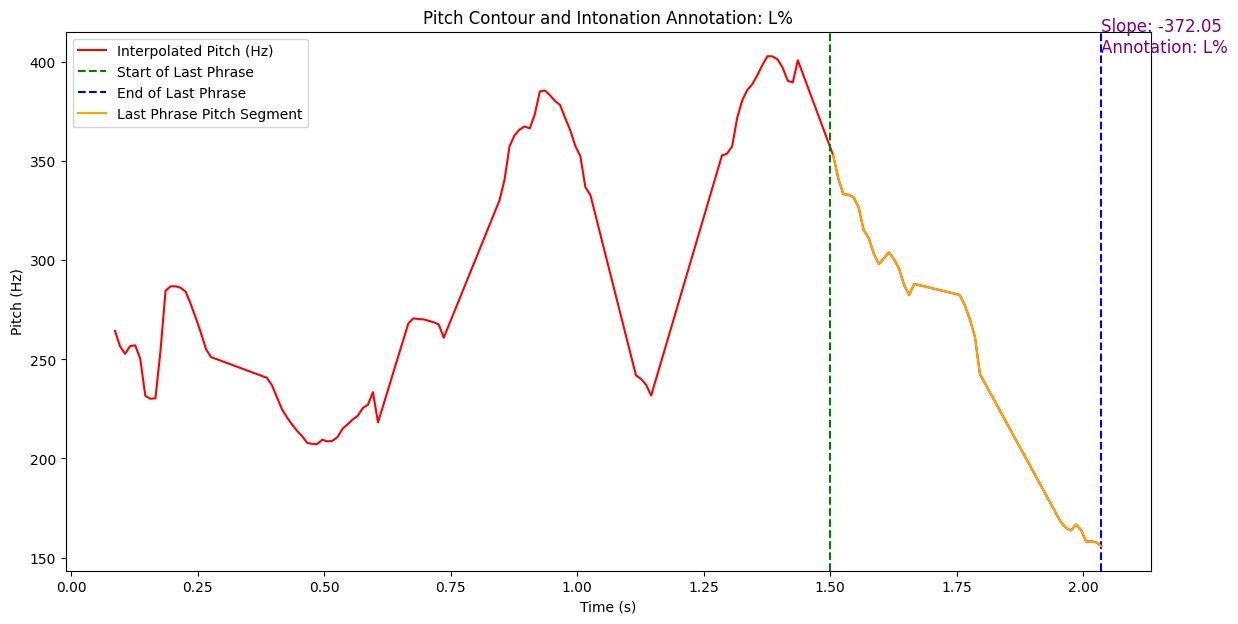

Intonation annotation: L%


In [ ]:
def calculate_pitch_slope(pitch_times, pitch_values, start_time, end_time):
    """
    Calculate the pitch slope within the specified time range.
    """
    # Filter pitch values within the specified range
    within_range = (pitch_times >= start_time) & (pitch_times <= end_time)
    segment_times = pitch_times[within_range]
    segment_values = pitch_values[within_range]

    # Ensure there are enough points to calculate slope
    if len(segment_times) < 2 or np.isnan(segment_values).all():
        return None, None, "Insufficient data"

    # Linear regression to calculate slope
    slope = (segment_values[-1] - segment_values[0]) / (segment_times[-1] - segment_times[0])
    return slope, segment_values, "Slope calculated"


def annotate_intonation(slope, segment_values, full_pitch_values, rise_threshold=0.5, flat_threshold=0.1):
    """
    Annotate intonation based on pitch slope and overall pitch context.
    """
    if slope is None:
        return "No annotation (insufficient data)"

    if slope > rise_threshold:
        return "H%"  # Rising intonation
    elif slope < -rise_threshold:
        return "L%"  # Falling intonation
    elif abs(slope) <= flat_threshold:
        # Check if last segment pitch is high or low relative to the full sentence
        full_mean_pitch = np.nanmean(full_pitch_values)
        segment_mean_pitch = np.nanmean(segment_values)
        return "H%" if segment_mean_pitch > full_mean_pitch else "L%"
    else:
        return "Flat"


def process_and_annotate_pitch(
    sound_path,
    # last_phrase_start=1.943,  # Hardcoded start time for last phrase
    last_phrase_start=1.5,  # Hardcoded start time for last phrase
    time_step=0.01,
    pitch_floor=100,
    pitch_ceiling=450,
    rise_threshold=0.5,
    flat_threshold=0.1
):
    """
    Process the sound file, calculate pitch slope, and annotate intonation.
    """
    # Load sound and extract pitch
    sound = parselmouth.Sound(sound_path)
    pitch = sound.to_pitch(time_step=time_step, pitch_floor=pitch_floor, pitch_ceiling=pitch_ceiling)
    pitch_values = pitch.selected_array['frequency']
    pitch_times = pitch.xs()

    # Replace unvoiced/unmeasured parts with NaN
    pitch_values[pitch_values == 0] = np.nan

    # Interpolate missing values
    valid_idx = ~np.isnan(pitch_values)
    interp_function = interp1d(
        pitch_times[valid_idx],
        pitch_values[valid_idx],
        kind="linear",
        bounds_error=False,
        fill_value=np.nan
    )
    interpolated_pitch = interp_function(pitch_times)

    # Define the end time as the last valid pitch measurement
    last_valid_time = pitch_times[~np.isnan(interpolated_pitch)][-1]

    # Calculate pitch slope for the last phrase
    slope, segment_values, status = calculate_pitch_slope(
        pitch_times, interpolated_pitch, last_phrase_start, last_valid_time
    )

    # Annotate intonation
    annotation = annotate_intonation(
        slope, segment_values, interpolated_pitch, rise_threshold, flat_threshold
    )

    # Visualize results
    visualize_pitch_and_annotation(
        pitch_times, interpolated_pitch, last_phrase_start, last_valid_time, slope, annotation
    )

    return annotation


def visualize_pitch_and_annotation(
    pitch_times, pitch_values, start_time, end_time, slope, annotation
):
    """
    Visualize the pitch contour and the intonation annotation.
    """
    within_range = (pitch_times >= start_time) & (pitch_times <= end_time)
    segment_times = pitch_times[within_range]
    segment_values = pitch_values[within_range]

    plt.figure(figsize=(14, 7))
    plt.plot(pitch_times, pitch_values, label="Interpolated Pitch (Hz)", color="red")
    plt.axvline(x=start_time, color="green", linestyle="--", label="Start of Last Phrase")
    plt.axvline(x=end_time, color="blue", linestyle="--", label="End of Last Phrase")
    plt.plot(segment_times, segment_values, label="Last Phrase Pitch Segment", color="orange")

    # Annotate slope and result
    if slope is not None:
        slope_text = f"Slope: {slope:.2f}"
    else:
        slope_text = "Slope: N/A"
    plt.text(end_time, np.nanmax(pitch_values), f"{slope_text}\nAnnotation: {annotation}",
             fontsize=12, color="purple", verticalalignment="bottom")

    plt.xlabel("Time (s)")
    plt.ylabel("Pitch (Hz)")
    plt.legend()
    plt.title(f"Pitch Contour and Intonation Annotation: {annotation}")
    plt.show()


# Example usage
sound_file = audio_file  # Replace with your actual sound file path
annotation = process_and_annotate_pitch(
    sound_file
)
print(f"Intonation annotation: {annotation}")


### 코드가 자동으로 마지막 피치 구간에서 추출한 마지막 음절 구간 (부정확하여 코드 수정 필요)

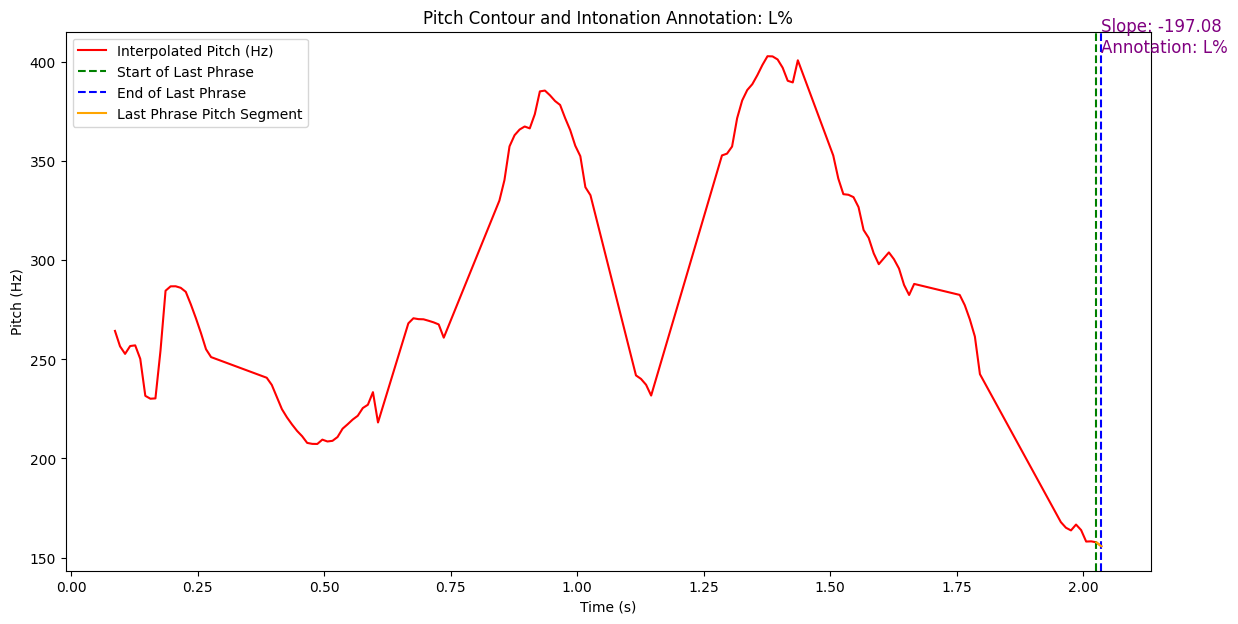

Intonation annotation: L%


In [ ]:
def calculate_pitch_slope(pitch_times, pitch_values, start_time, end_time):
    """
    Calculate the pitch slope within the specified time range.
    """
    # Filter pitch values within the specified range
    within_range = (pitch_times >= start_time) & (pitch_times <= end_time)
    segment_times = pitch_times[within_range]
    segment_values = pitch_values[within_range]

    # Ensure there are enough points to calculate slope
    if len(segment_times) < 2 or np.isnan(segment_values).all():
        return None, None, "Insufficient data"

    # Linear regression to calculate slope
    slope = (segment_values[-1] - segment_values[0]) / (segment_times[-1] - segment_times[0])
    return slope, segment_values, "Slope calculated"


def annotate_intonation(slope, segment_values, full_pitch_values, rise_threshold=0.5, flat_threshold=0.1):
    """
    Annotate intonation based on pitch slope and overall pitch context.
    """
    if slope is None:
        return "No annotation (insufficient data)"

    if slope > rise_threshold:
        return "H%"  # Rising intonation
    elif slope < -rise_threshold:
        return "L%"  # Falling intonation
    elif abs(slope) <= flat_threshold:
        # Check if last segment pitch is high or low relative to the full sentence
        full_mean_pitch = np.nanmean(full_pitch_values)
        segment_mean_pitch = np.nanmean(segment_values)
        return "H%" if segment_mean_pitch > full_mean_pitch else "L%"
    else:
        return "Flat"


def process_and_annotate_pitch(
    sound_path,
    time_step=0.01,
    pitch_floor=100,
    pitch_ceiling=450,
    rise_threshold=0.5,
    flat_threshold=0.1
):
    """
    Process the sound file, calculate pitch slope, and annotate intonation.
    """
    # Load sound and extract pitch
    sound = parselmouth.Sound(sound_path)
    pitch = sound.to_pitch(time_step=time_step, pitch_floor=pitch_floor, pitch_ceiling=pitch_ceiling)
    pitch_values = pitch.selected_array['frequency']
    pitch_times = pitch.xs()

    # Replace unvoiced/unmeasured parts with NaN
    pitch_values[pitch_values == 0] = np.nan

    # Interpolate missing values
    valid_idx = ~np.isnan(pitch_values)
    interp_function = interp1d(
        pitch_times[valid_idx],
        pitch_values[valid_idx],
        kind="linear",
        bounds_error=False,
        fill_value=np.nan
    )
    interpolated_pitch = interp_function(pitch_times)

    # Define the end time as the last valid pitch measurement
    last_valid_time = pitch_times[~np.isnan(interpolated_pitch)][-1]

    # Define the start time for the last phrase as the start time of the last valid pitch segment
    valid_times = pitch_times[~np.isnan(pitch_values)]
    if len(valid_times) > 1:
        last_phrase_start = valid_times[-2]  # Start of the last valid pitch segment
    else:
        last_phrase_start = valid_times[0]  # Fallback to the first valid time

    # Calculate pitch slope for the last phrase
    slope, segment_values, status = calculate_pitch_slope(
        pitch_times, interpolated_pitch, last_phrase_start, last_valid_time
    )

    # Annotate intonation
    annotation = annotate_intonation(
        slope, segment_values, interpolated_pitch, rise_threshold, flat_threshold
    )

    # Visualize results
    visualize_pitch_and_annotation(
        pitch_times, interpolated_pitch, last_phrase_start, last_valid_time, slope, annotation
    )

    return annotation


def visualize_pitch_and_annotation(
    pitch_times, pitch_values, start_time, end_time, slope, annotation
):
    """
    Visualize the pitch contour and the intonation annotation.
    """
    within_range = (pitch_times >= start_time) & (pitch_times <= end_time)
    segment_times = pitch_times[within_range]
    segment_values = pitch_values[within_range]

    plt.figure(figsize=(14, 7))
    plt.plot(pitch_times, pitch_values, label="Interpolated Pitch (Hz)", color="red")
    plt.axvline(x=start_time, color="green", linestyle="--", label="Start of Last Phrase")
    plt.axvline(x=end_time, color="blue", linestyle="--", label="End of Last Phrase")
    plt.plot(segment_times, segment_values, label="Last Phrase Pitch Segment", color="orange")

    # Annotate slope and result
    if slope is not None:
        slope_text = f"Slope: {slope:.2f}"
    else:
        slope_text = "Slope: N/A"
    plt.text(end_time, np.nanmax(pitch_values), f"{slope_text}\nAnnotation: {annotation}",
             fontsize=12, color="purple", verticalalignment="bottom")

    plt.xlabel("Time (s)")
    plt.ylabel("Pitch (Hz)")
    plt.legend()
    plt.title(f"Pitch Contour and Intonation Annotation: {annotation}")
    plt.show()


# Example usage
sound_file = audio_file  # Replace with your actual sound file path
annotation = process_and_annotate_pitch(
    sound_file
)
print(f"Intonation annotation: {annotation}")


# 6. 선형회귀 선으로 기울기를 표현

In [ ]:
import parselmouth
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

def calculate_pitch_slope(pitch_times, pitch_values, start_time, end_time):
    """
    Calculate the pitch slope within the specified time range.
    """
    # Filter pitch values within the specified range
    within_range = (pitch_times >= start_time) & (pitch_times <= end_time)
    segment_times = pitch_times[within_range]
    segment_values = pitch_values[within_range]

    # Ensure there are enough points to calculate slope
    if len(segment_times) < 2 or np.isnan(segment_values).all():
        return None, None, "Insufficient data"

    # Linear regression to calculate slope
    model = LinearRegression()
    model.fit(segment_times.reshape(-1, 1), segment_values)
    slope = model.coef_[0]
    return slope, segment_values, model, "Slope calculated"

def annotate_intonation(slope, segment_values, full_pitch_values, rise_threshold=0.5, flat_threshold=0.1):
    """
    Annotate intonation based on pitch slope and overall pitch context.
    """
    if slope is None:
        return "No annotation (insufficient data)"

    if slope > rise_threshold:
        return "H%"  # Rising intonation
    elif slope < -rise_threshold:
        return "L%"  # Falling intonation
    elif abs(slope) <= flat_threshold:
        # Check if last segment pitch is high or low relative to the full sentence
        full_mean_pitch = np.nanmean(full_pitch_values)
        segment_mean_pitch = np.nanmean(segment_values)
        return "H%" if segment_mean_pitch > full_mean_pitch else "L%"
    else:
        return "Flat"

def process_and_annotate_pitch(
    sound_path,
    last_phrase_start=1.943,  # Hardcoded start time for last phrase
    time_step=0.01,
    pitch_floor=100,
    pitch_ceiling=450,
    rise_threshold=0.5,
    flat_threshold=0.1
):
    """
    Process the sound file, calculate pitch slope, and annotate intonation.
    """
    # Load sound and extract pitch
    sound = parselmouth.Sound(sound_path)
    pitch = sound.to_pitch(time_step=time_step, pitch_floor=pitch_floor, pitch_ceiling=pitch_ceiling)
    pitch_values = pitch.selected_array['frequency']
    pitch_times = pitch.xs()

    # Replace unvoiced/unmeasured parts with NaN
    pitch_values[pitch_values == 0] = np.nan

    # Interpolate missing values
    valid_idx = ~np.isnan(pitch_values)
    interp_function = interp1d(
        pitch_times[valid_idx],
        pitch_values[valid_idx],
        kind="linear",
        bounds_error=False,
        fill_value=np.nan
    )
    interpolated_pitch = interp_function(pitch_times)

    # Define the end time as the last valid pitch measurement
    last_valid_time = pitch_times[~np.isnan(interpolated_pitch)][-1]

    # Calculate pitch slope for the last phrase
    slope, segment_values, regression_model, status = calculate_pitch_slope(
        pitch_times, interpolated_pitch, last_phrase_start, last_valid_time
    )

    # Annotate intonation
    annotation = annotate_intonation(
        slope, segment_values, interpolated_pitch, rise_threshold, flat_threshold
    )

    # Visualize results
    visualize_pitch_and_annotation(
        pitch_times, interpolated_pitch, last_phrase_start, last_valid_time, slope, annotation, regression_model
    )

    return annotation


def visualize_pitch_and_annotation(
    pitch_times, pitch_values, start_time, end_time, slope, annotation, regression_model
):
    """
    Visualize the pitch contour, intonation annotation, and linear regression line.
    """
    within_range = (pitch_times >= start_time) & (pitch_times <= end_time)
    segment_times = pitch_times[within_range]
    segment_values = pitch_values[within_range]

    plt.figure(figsize=(14, 7))
    plt.plot(pitch_times, pitch_values, label="Interpolated Pitch (Hz)", color="red")
    plt.axvline(x=start_time, color="green", linestyle="--", label="Start of Last Phrase")
    plt.axvline(x=end_time, color="blue", linestyle="--", label="End of Last Phrase")
    plt.plot(segment_times, segment_values, label="Last Phrase Pitch Segment", color="orange")

    # Plot the regression line
    regression_line = regression_model.predict(segment_times.reshape(-1, 1))
    plt.plot(segment_times, regression_line, label="Linear Regression Line", color="purple", linestyle="--")

    # Annotate slope and result
    if slope is not None:
        slope_text = f"Slope: {slope:.2f}"
    else:
        slope_text = "Slope: N/A"
    plt.text(end_time, np.nanmax(pitch_values), f"{slope_text}\nAnnotation: {annotation}",
             fontsize=12, color="purple", verticalalignment="bottom")

    plt.xlabel("Time (s)")
    plt.ylabel("Pitch (Hz)")
    plt.legend()
    plt.title(f"Pitch Contour and Intonation Annotation: {annotation}")
    plt.show()





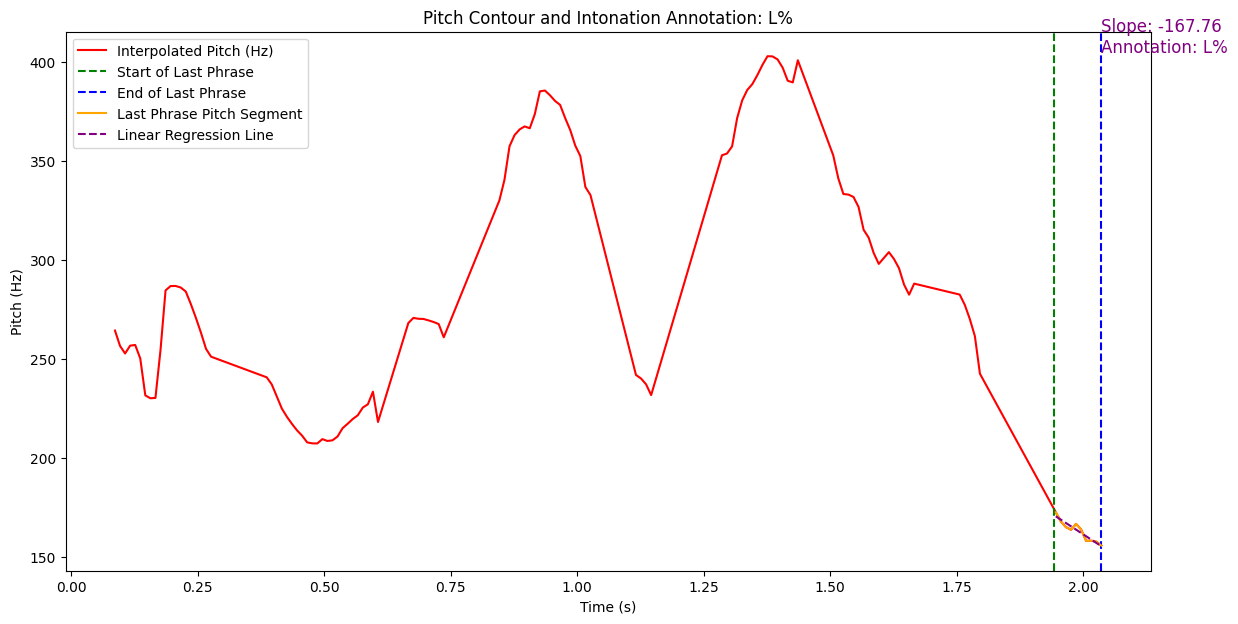

Intonation annotation: L%


In [ ]:
# Example usage
sound_file = audio_file  # Replace with your actual sound file path
annotation = process_and_annotate_pitch(
    sound_file
)
print(f"Intonation annotation: {annotation}")

# 7. 음성 말뭉치 전체에 적용

In [ ]:
# import os
# import pandas as pd
# import parselmouth
# import numpy as np
# from scipy.interpolate import interp1d
# import matplotlib.pyplot as plt


# Batch processing for folder
wav_folder = "/content/drive/MyDrive/aiffel/aiffelthon/감정이태깅된자유대화_샘플_개별발화"  # Replace with the path to your .wav files
csv_path = ""  # Replace with the path to your CSV file
output_csv_path = "<your_output_csv_path>"  # Replace with the path for the output CSV

dataframe = pd.read_csv(csv_path)
dataframe["slope"] = None
dataframe["annotation"] = None

for wav_file in os.listdir(wav_folder):
    if wav_file.endswith(".wav"):
        base_name = os.path.splitext(wav_file)[0]

        if base_name in dataframe["file_name"].values:  # Assuming 'file_name' is the column to match
            wav_path = os.path.join(wav_folder, wav_file)

            try:
                slope, annotation = process_and_annotate_pitch(wav_path)
                dataframe.loc[dataframe["file_name"] == base_name, "slope"] = slope
                dataframe.loc[dataframe["file_name"] == base_name, "annotation"] = annotation
            except Exception as e:
                print(f"Error processing {wav_file}: {e}")

# Save the updated dataframe
dataframe.to_csv(output_csv_path, index=False)


# 8. dacon: 억양 주석부터 다시 만듦

In [ ]:
import os
import pandas as pd
import librosa  # pitch 추출을 위해
import numpy as np
from scipy.signal import find_peaks

# 1. CSV 파일 로드
csv_file_path = '/content/filtered_train.csv'
df = pd.read_csv(csv_file_path)

# 새로운 폴더 경로 지정
output_folder = '/content/with_features'
os.makedirs(output_folder, exist_ok=True)

# 2. pitch 기울기 추출 및 억양 주석 달기
def extract_pitch_and_intonation(file_path):
    # librosa로 .wav 파일 로드
    y, sr = librosa.load(file_path)

    # Pitch 추출: librosa의 pitch 추정 함수 사용 (음성의 주파수 추정)
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)

    # 각 시간 프레임에서 가장 높은 pitch를 추출
    pitch = []
    for t in range(pitches.shape[1]):
        index = magnitudes[:, t].argmax()
        pitch.append(pitches[index, t])

    # pitch 기울기 계산
    pitch = np.array(pitch)
    pitch_slope = np.gradient(pitch)  # 기울기 추출

    # 억양 주석: pitch 변화량이 큰 부분을 강조
    peaks, _ = find_peaks(pitch_slope, height=0.1)  # 임계값은 조정 가능
    intonation_annotation = ['rising' if i in peaks else 'falling' for i in range(len(pitch_slope))]

    return pitch_slope, intonation_annotation

# 3. 각 파일에 대해 pitch 기울기와 억양 주석 추가
pitch_slope_list = []
intonation_annotation_list = []

# for index, row in df.iterrows():
#     file_path = os.path.join('./content', row['path'])
for index, row in df.iterrows():
    # row['path']의 ./train을 /content/train_data로 변환
    file_path = row['path'].replace('./train', '/content/train_data')
    print(file_path)  # 확인용 출력 (필요 시 제거)

    pitch_slope, intonation_annotation = extract_pitch_and_intonation(file_path)

    pitch_slope_list.append(pitch_slope)
    intonation_annotation_list.append(intonation_annotation)

# 4. 새로운 컬럼을 기존 DataFrame에 추가
df['pitch_slope'] = pitch_slope_list
df['intonation_annotation'] = intonation_annotation_list

# 5. 새로운 .csv 파일로 저장
output_csv_path = os.path.join(output_folder, 'train_data_with_pitch_and_intonation.csv')
df.to_csv(output_csv_path, index=False)

print(f"새로운 데이터가 {output_csv_path}에 저장되었습니다.")


/content/train_data/TRAIN_0005.wav
/content/train_data/TRAIN_0064.wav
/content/train_data/TRAIN_0082.wav
/content/train_data/TRAIN_0146.wav
/content/train_data/TRAIN_0253.wav
/content/train_data/TRAIN_0263.wav
/content/train_data/TRAIN_0440.wav
/content/train_data/TRAIN_0572.wav
/content/train_data/TRAIN_0597.wav
/content/train_data/TRAIN_0606.wav
/content/train_data/TRAIN_0643.wav
/content/train_data/TRAIN_0875.wav
/content/train_data/TRAIN_0899.wav
/content/train_data/TRAIN_1001.wav
/content/train_data/TRAIN_1010.wav
/content/train_data/TRAIN_1019.wav
/content/train_data/TRAIN_1152.wav
/content/train_data/TRAIN_1188.wav
/content/train_data/TRAIN_1218.wav
/content/train_data/TRAIN_1226.wav
/content/train_data/TRAIN_1286.wav
/content/train_data/TRAIN_1316.wav
/content/train_data/TRAIN_1319.wav
/content/train_data/TRAIN_1368.wav
/content/train_data/TRAIN_1370.wav
/content/train_data/TRAIN_1377.wav
/content/train_data/TRAIN_1410.wav
/content/train_data/TRAIN_1438.wav
/content/train_data/

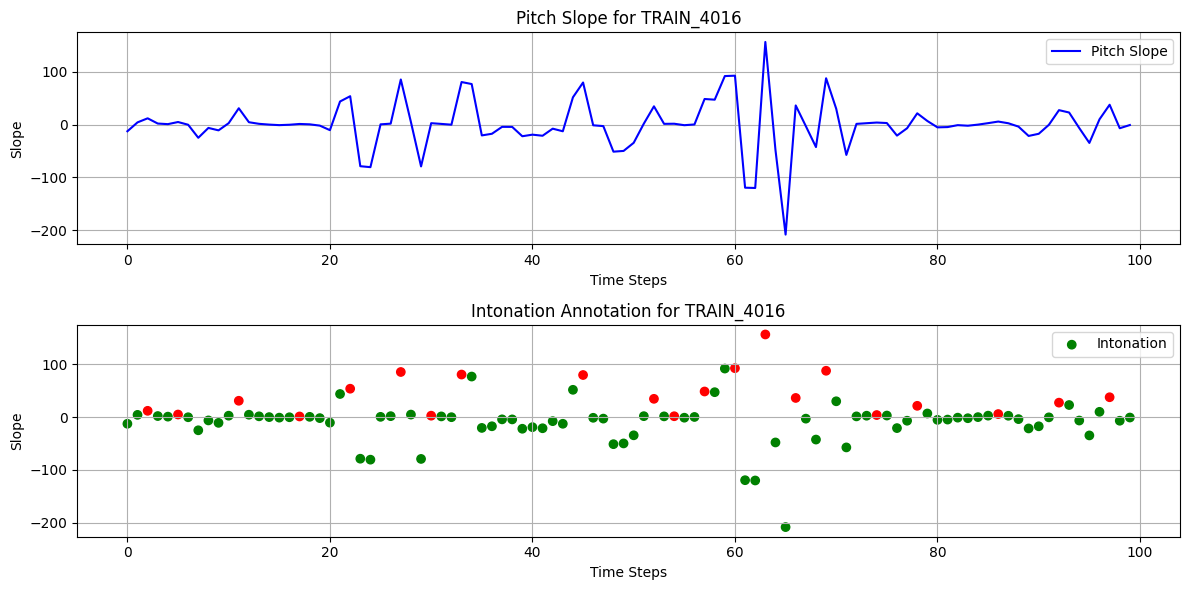

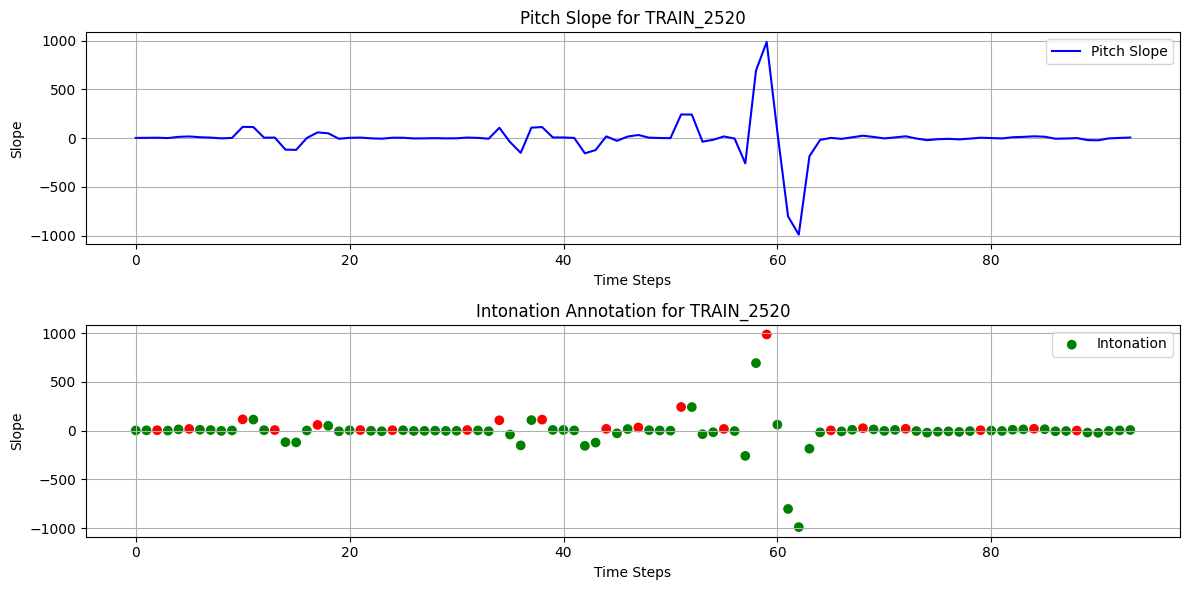

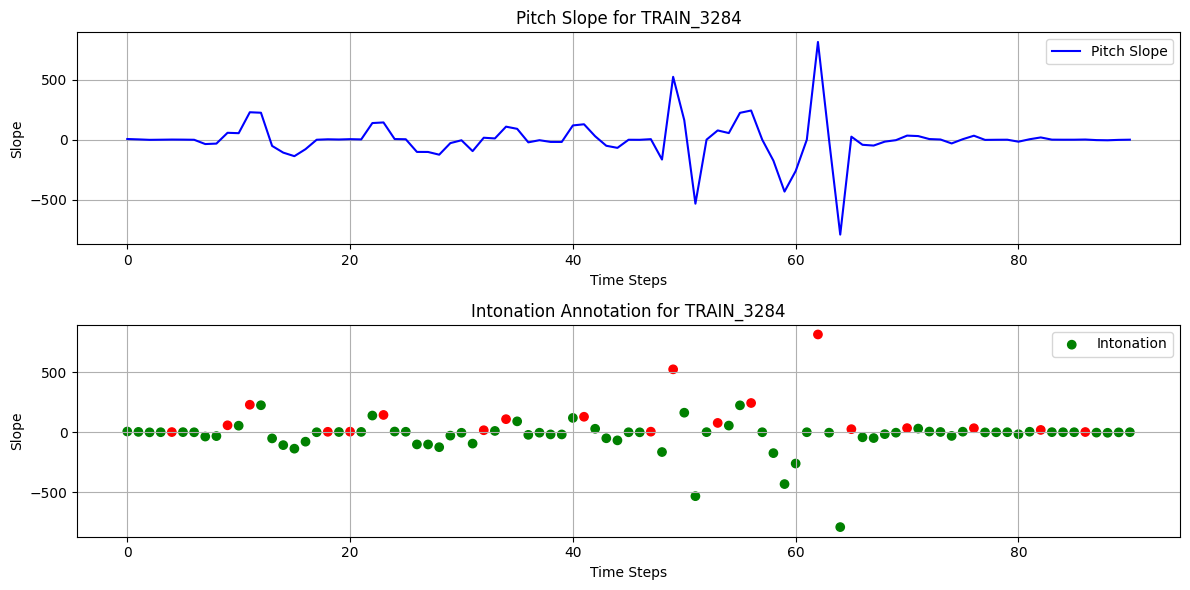

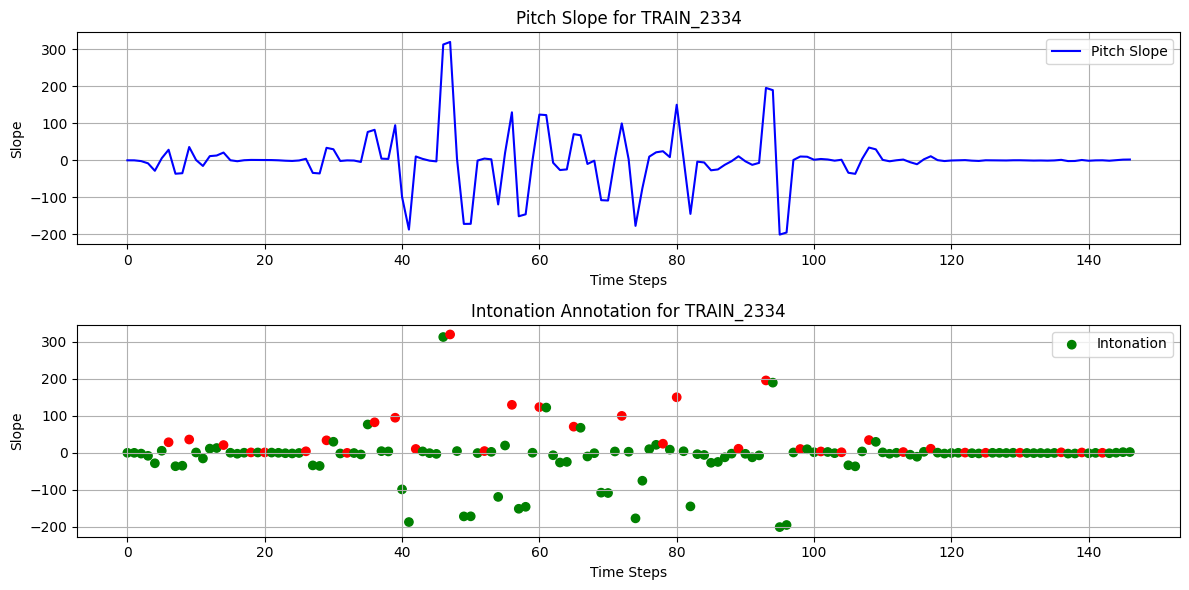

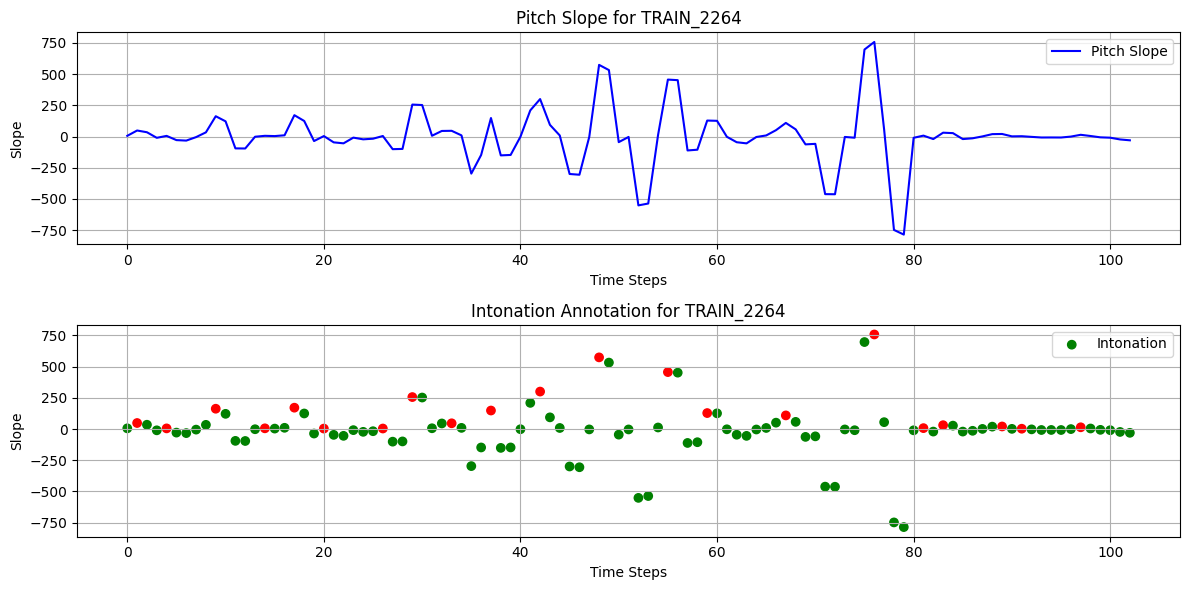

In [ ]:
import matplotlib.pyplot as plt
import random

# 샘플 5개 선택
sample_rows = df.sample(n=5, random_state=42)

# 시각화 함수 정의
def visualize_pitch_and_intonation(row):
    file_name = row['id']
    pitch_slope = row['pitch_slope']
    intonation_annotation = row['intonation_annotation']

    # 시간 축 생성
    time_steps = range(len(pitch_slope))

    # 시각화
    plt.figure(figsize=(12, 6))

    # pitch 기울기 플롯
    plt.subplot(2, 1, 1)
    plt.plot(time_steps, pitch_slope, label='Pitch Slope', color='blue')
    plt.title(f'Pitch Slope for {file_name}')
    plt.xlabel('Time Steps')
    plt.ylabel('Slope')
    plt.grid(True)
    plt.legend()

    # 억양 레이블링 플롯
    plt.subplot(2, 1, 2)
    plt.scatter(time_steps, pitch_slope, c=['red' if label == 'rising' else 'green' for label in intonation_annotation], label='Intonation')
    plt.title(f'Intonation Annotation for {file_name}')
    plt.xlabel('Time Steps')
    plt.ylabel('Slope')
    plt.grid(True)
    plt.legend()

    # 그래프 출력
    plt.tight_layout()
    plt.show()

# 샘플 데이터 시각화
for _, row in sample_rows.iterrows():
    visualize_pitch_and_intonation(row)
